Проведите следующие эксперименты используя алгоритм Q-обучения с приоритизированным буфером памяти:

* Обучите алгоритм с значением гиперпараметра `PER_A = 1`

* Обучите алгоритм с значением гиперпараметра `PER_A = -1`

* Обучите алгоритм с значением гиперпараметров `PER_B = 1` и `PER_B_increment_sampling` = 0

* Обучите алгоритм с значением гиперпараметров `PER_B = 0` и `PER_B_increment_sampling` = 0

Запишите итоговую точность на каждый эксперимент. Также, для каждого эксперимента, нужно написать в своих словах, как данные значения влияют на логику работы алгоритма 

Пример того, что нужно написать про логику алгоритма: `значение PER_A = 0 полностью удаляет весь механизм приоритета в буфере памяти`.

**Подсказка:** Можно уменьшить значение параметра `epsilon_decay_factor` чтобы алгоритм обучался быстрее.

Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нам нужно сначала установить различные дополнительные программы которые упомянаются в официальной документации.

In [ ]:
%%bash
#%%bash - значит используем командную строку (не код питона)
# Устанавливаем нужные программы, которая требует от нас документация: https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.0 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-update

Затем, устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории.

In [ ]:
#Обычно уходит 5-10 минут на установку этой библиотеки.
!pip install vizdoom==1.1.9

     |████████████████████████████████| 15.0 MB 159 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.9-py3-none-any.whl size=14084060 sha256=4d81865086d777a035e75f4f723f0eb2ea62d1f995f5f593a23076a635c62048
  Stored in directory: /root/.cache/pip/wheels/89/75/34/2c03a5cc9d572ad08bed39e67bf0da279f63b03864a3aa2c66
Successfully built vizdoom


Сначала, скачиваем все нужные файлы для ViZDoom.

In [ ]:
import gdown #Импортируем модуль для скачивания датасетов

#Скачиваем файлы для ViZDoom
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/6_RL/rl.zip', output = None, quiet = True)
!unzip -qo rl.zip -d /content/ViZDoom/ #Разархивируем файлы

Импортируем все нужные модули и библиотеки.

In [ ]:
from vizdoom import *         #Импортируем все функции из cреды ViZDoom
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop, Adam             #Импортируем оптимизаторы RMSprop и Adam
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга
from moviepy.editor import *                                      #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
from google.colab import output                                   #Импортируем функцию для управления вывода в колаб-ячейках

import heapq
import numpy as np
from itertools import count

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1925120/45929032 bytes (4.2%)4710400/45929032 bytes (10.3%)7405568/45929032 bytes (16.1%)10272768/45929032 bytes (22.4%)12992512/45929032 bytes (28.3%)15867904/45929032 bytes (34.5%)18522112/45929032 bytes (40.3%)21389312/45929032 bytes (46.6%)24379392/45929032 bytes (53.1%)27394048/45929032 bytes (59.6%)30351360/45929032 bytes (66.1%)33153024/45929032 bytes (72.2%)

# Код из лекции

Этот код немного изменен, чтобы различные функции могли работать с переменными которые находяться не в глобальной среде, а в локальной.

Дуэльная сеть будет вычислять не только значения Q(s, a) для каждого состояния, но также будет сравривать его с предположенным текущим V(s). Этот процесс может происходить внутри самой архитектуры нейронной сети, если мы её создадим используя две отдельные ветки: ветка значения (value branch) и ветка преймущества (advantage branch).

Архитектура этой нейронной сети создана с учётом принципов компютерного видение, одно из которых гласит что размер рецептового поля свёрточного блока должен быть максимально близок к размеру картинки.

In [ ]:
def dueling_DQN(input_shape, action_size, learning_rate):
  state_input = Input(shape=(input_shape))   #Создаем входной слой нейронной сети. Размерность входных кадров будет 64 х 64
  x = Conv2D(32, 4, strides=(2, 2), activation='relu')(state_input)         #Добавляем первый свёрточный слой
  x = Conv2D(48, 3, strides=(2, 2), activation='relu')(x)                   #Добавляем второй свёрточный слой 
  x = Conv2D(64, 3, strides=(2, 2), activation='relu')(x)                   #Добавляем третий свёрточный слой 
  x = Conv2D(96, 3, strides=(2, 2), activation='relu')(x)                   #Добавляем четвёртый свёрточный слой 
  x = Conv2D(128, 3, strides=(1, 1), activation='relu')(x)                  #Добавляем пятый свёрточный слой, у которого размерность выходных фичей будет 1х1 (как теоретический должно быть в любой свёрточной сети)
  x = Flatten()(x)                                          #Добавляем выравнивающий слой

  # Ветка значения состояния - пытается предсказать значения состояния V(s)
  state_value = Dense(256, activation='relu')(x)          #Добавляем скрытый полносвязанный слой с 256 нейронами
  state_value = Dense(1)(state_value)                     #Добавляем полносвязанный слой с 1 нейроном, который будет считать скалярное значение V(s)
  #Нам нужно добавить размерность к этому слою для дальшейшего суммирование с веткой преймущества. Это делается через лямбда слой.
  state_value = Lambda(lambda s: K.expand_dims(s[:, 0], axis=-1), output_shape=(action_size,))(state_value) 

  # Ветка преймущества действия - пытается предсказать значения преймущества А(s, а) для каждого возможного действия а
  action_advantage = Dense(256, activation='relu')(x)     #Добавляем скрытый полносвязанный слой с 256 нейронами
  action_advantage = Dense(action_size)(action_advantage) #Добавляем полносвязанный слой с action_size количеством нейронов (action_size это количество уникальных возможных действий)
  #Чтобы "заставить" эту ветку считать преймущества, мы добавляем самописную функцию, которая вычитывает среднее значение. Таким образом, все преймущества 
  #которые ниже среднего становяться отрициательными, а все значения которые выше среднего остаються положительными.
  action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_size,))(action_advantage) 

  # Суммируем преймущества и значения состояний чтобы получить Q(s, a) для каждого возможного действия а
  state_action_value = Add()([state_value, action_advantage])

  model = Model(state_input, state_action_value) #Создаем модель, которая принимает на вход состояние среды и возвращает все значения Q(s, a)
  model.compile(loss = loss_function, optimizer = Adam(learning_rate = learning_rate)) #Компилизуем модель используя функцию ошибки которую объявляем ниже
  return model   #Функция возвращает модель

---
**Здесь заканчиваются отличия между DDQN и Duelling DDQN. Всё, что содержиться в коде дальше - это просто альтернативный способ реализации общих принципов обеих алгоритмов.**

---



Улучшенная сеть также будет использовать особенную функцию ошибки, которая часто используется для задачи Q-learning. Эта функция ошибки известна как Ошибка Хубера (Huber Loss). 

Математическая функция Хубера использует гиперпараметр ẟ (который обычно обозначается как 1). Функция Хубера выглядет следующим образом: 

---

H(x) = x<sup>2</sup> если -ẟ <= x <= ẟ (средняя квадратичная ошибка)

иначе
 
H(x) = |x| (средняя абсолютная ошибка)

delta - гиперпараметр который используется в функции ошибки Хубера. Обычно, этот гиперпараметр равен 1, но в данном коде используется низкое значение (подразумивается, что это приведёт к более равным градиентом, что поможет нейронной сети обучаться - однако стоит отметить что этот параметр не очень сильно влияет на общий смысл функции ошибки).

In [ ]:
#Объявляем ошибку Хубера
loss_function = tf.keras.losses.Huber(delta = 2)

Prioritized Experience Replay

Следующий код создает наиболее усовершенствованный буфер памяти, используя алгоритм который известен как Prioritized Experience Replay.

Суть такого буфера памяти - наиболее часто сэмплить более "полезные" данные, которые могут появляться относительно редко. В качестве метрики оценки "полезности" данных используется разцина между предсказанными и 'истинными' значениями Q(s, a) (истинные значения, в данном случае, это то что предсказывается с учётом целевой модели).

Для реализации данного алгоритма нужно будет сначало отсортировать все данные по их приоритету, что займет очень много времени, т.к. массив памяти большой и его приходиться сортировать очень часто. Чтобы уменьшить требования к вычистительным ресурсам, мы будем использовать структуру данных известную как 'бинарное дерево' для сортировки данных. Премущество такой структуры данных заключается в том, что мы можем добовлять новые данные и сортировать их в нужных порядок гораздо быстрее.

**Важно** - Эта структука данных является деревом сумм, что значит - значения каждого листа равняется суммой всех его дочерних узлов. В каждом узле будет записываться приоритет данных.





**Список параметров приоритезированного буфера памяти**

* PER_A - параметр, который влияет на степень "приоритета" более важных данных. Если параметр приближается 0, распределение сэмплов становиться более равномерным. Чем больше этот параметр, тем больше приоритета отдается более редким данным.

* PER_B - параметр, который определяет веса, которые конкретные примеры данных будут иметь на функцию ошибки при обучение нейронной сети. Если этот параметр приближается к 0, все данные будут иметь такой же вес на функцию ошибки, а чем больше этот параметр, тем меньше влияния на функцию ошибки будут указывать наиболее редкие данные, т.к. эти данные избираются относительно часто для обучения. Значение этого параметра обычно меняется при обучении, PER_B увеличивается.

* PER_B_increment_sampling - количество, но сколько параметр PER_B увеличивается после каждой итерации обучения. Обычно PER_B увеличивается во время обучения сети, но не может превышать 1. Это нужно делать, по сколько обучение изначально не стабильно и веса сэмплов должны быть более равномерными.

* absolute_error_minimum - параметр который определяет минимальную степень "важности" каждого примера из датасета. Чем выше этот параметр, тем более равномерное распределение при сэмплировании данных.

* absolute_error_maximum - параметр который определяет максимальную степень "важности" каждого примера из датасета. Чем ниже этот параметр, тем более равномерное распределение при сэмплировании данных. Если R это максимальная возможная награда за действия, то значение этого параметра не должно превышать R<sup>PER_A</sup>

In [ ]:
#Инициализируем класс для бинарного дерево.
class Priority_Tree:
  data_pointer = 0 #В самом начале инициализируем переменную data_pointer как 0. Позже, эта переменная будет показывать на нужный пример данных по индексу.
  
  def __init__(self, memory_capacity):                            #Класс принимает максимальный размер памяти на вход.
    self.memory_capacity = memory_capacity                        #Записываем максимальный доступный размер в аттрибут класса
    self.tree = np.zeros(2 * memory_capacity - 1)                 #Дерево приоритета инициализируется нулями, но будет заполняться числами. Чем выше числор, тем выше приоритет соответствующих данных.
    self.data = np.zeros(memory_capacity, dtype = object)         #Этот массив будет содержать данные из игровой среды. У него тип данных object по скольку он будет содержать разные типы данных в виде кортежей (действия, состояния, и тд.)
    self.memory_size = 0                                          #Добавим аттрибут, который будет показывать на количество данных в массиве (это не часть алгоритма, используется для удобства).

  #ВАЖНО!!!: размерность tree отличается от размерности data, потому что tree - это целое дерево, и все кроме последнего уровня этого дерева существуют лишь для ускоренного поиска. 
  #Приоритеты данных храняться в нижнем слое дерева, то есть с индекса memory_capacity до 2 * memory_capacity - 1 ([memory_capacity : 2*memory_capacity-1])

  #Этот метод будет использоваться при добавлении новых данных в дерево. 
  #Метод принимает данные, которые нужно добавить, и их приоритет.
  def add(self, data, priority):
    tree_index = self.data_pointer + self.memory_capacity - 1 #Задаем индекс данных в дереве приоритета. 
    self.data[self.data_pointer] = data                       #Записываем новые данные в индекс, который указывает data_pointer
    self.update(tree_index, priority)                         #Вызываем метод для обновления всех значений по дереву (этот меод объявляется ниже)
    self.data_pointer += 1                                    #Увеличиваем индекс data_pointer на 1
    if self.data_pointer >= self.memory_capacity:             #Если data_pointer больше, чем размер памяти:
      self.data_pointer = 0                                   #Устанавливаем data_pointer как 0 и начинаем его увеличивать сначала (это поможет удалить очень старые данные)
    
    self.memory_size = min(self.memory_size + 1, self.memory_capacity) #Увеличиваем текущий размер памяти на 1, но убеждаемся что он не больше чем memory_capacity (это не часть алгоритма, используется для удобства).

  #Объявляем метод для обновления всех приоритетов в дереве, он вызывается когда мы добавляем новые данные в дерево. 
  #Метод принимает на вход текущий индекс дерева, и приоритет по которому нужно обновить.
  def update(self, tree_index, priority):
    change = priority - self.tree[tree_index] #Считаем разцину в приоритете (текущий приоритет минус то, что уже есть на этом месте)
    self.tree[tree_index] = priority          #Устанавливаем новый приоритет в лист дерева.
    while tree_index != 0:                    #В этом цикле ищем все данные по ветке, пока не достигаем начало дерева.
      tree_index = (tree_index - 1)//2        #Берём индекс родительского листа
      self.tree[tree_index] += change         #И увеличиваем его приоритет на параметр change.

  #Объявляем метод, который позволит нам извлечь индекс, приоритет, и данные соответствующие одному узлу из дерева.
  #Процесс поиска значения в дереве - метод принимает на вход значение приоритета, по которому мы извлекаем пример данных.
  def get_leaf(self, value):
    parent_index = 0                              #Индекс родительского узла - инициализируется как 0
    while True:                                   #В цикле ищем нужный нам узел.
      left_child_index = 2 * parent_index + 1     #По определению, левый дочерний узел всегда имеет такой индекс по отношению с его родительски узлом.
      right_child_index = left_child_index + 1    #По определению, правый дочерний узел всегда имеет индекс равен левому дочерному излу + 1.

      if left_child_index >= len(self.tree):      #Если индекс левого дочерного узла, который мы рассматриваем, больше чем размер дерево - значит мы уже на максимальной глубине дерева.
        leaf_index = parent_index                 #По этому, нужный индекс становиться родительским индексом, и мы выходим из цикла. 
        break
      elif value <= self.tree[left_child_index]:  #Иначе если значение меньше чем левый дочерний узел дерева:
        parent_index = left_child_index           #Мы записываем левый дочерний индекс как родительский индекс.
      else:
        value -= self.tree[left_child_index]      #Иначе, если значение НЕ меньше чем левый дочерний узел дерева и мы НЕ на максимальной глубине дерева:
        parent_index = right_child_index          #родительским индексом становиться правый дочерний индекс и значение уменьшается на приоритет левого дочернего узла (по определению, так происходит поиск нужного значения в дереве сумм).

    data_index = leaf_index - self.memory_capacity + 1                #Индекс из массива равен индекс из дерева - размер_памяти + 1
    return leaf_index, self.tree[leaf_index], self.data[data_index]   #Возвращаем индекс узла, приоритет индекса из дерева приоритетов, и соответствующие сэмплы данных.

  @property                    #Добавляем метод с декоратором свойства.
  def total_priority(self):
    return self.tree[0]        #Этот метод возвращает приоритет первого элемента (что по определению является суммой всех остальных приоритетов).

#Дальше создаем класс для возпроизведение приоритетного опыта. В этом классе есть два основных параметра, которые мы называем A и B.
class Prioritized_Experience_Replay:
  #Класс принимает на вход различные параметры для буфера памяти, включая те, которые нужно менять в экспериментах.
  def __init__(self, memory_capacity, PER_A = 0.6, PER_B = 0.4, PER_B_increment_sampling = 1e-5):  
    self.priority_tree = Priority_Tree(memory_capacity)     #Создаем объект приоритетного дерево внутри этого класса.
    self.PER_A = PER_A   #Задаем значение параметра A
    self.PER_B = PER_B   #Задаем значение параметра B

    self.PER_B_increment_sampling = PER_B_increment_sampling  #Также есть параметр PER_B_increment_sampling, который будет влиять на то, как быстро меняется параметр PER_B во время обучения сети.
    self.absolute_error_minimum = 0.01                        #Этот параметр отвечает за "минимальную" ошибку. Если ошибка в предсказании ниже, чем этот параметр, мы меняем эту ошибку на значения параметра. Это делается чтобы всегда была какая-то вероятность выбора всех данных.
    self.absolute_error_maximum = 10.0                        #Последний параметр отвечает за максимальную "ошибку", которая будет учитываться (т.е. максимальный возможный приоритет). Этот параметр нужно подбирать в соответствии величин наград из среды.

  #Объявляем метод для сохранения новых данных. Как обычно, данные это - предыдущее состояние, действие, награда, следующее состояние, и статус завершение игры. 
  def store(self, experience):
    maximum_priority = np.max(self.priority_tree.tree[-self.priority_tree.memory_capacity:]) #Смотрим на максимальный приоритет в дереве среди данных в самом низу дерево (у которых нету дочернего узла).

    if maximum_priority == 0:                       #Если максимальный приоритет отсутствует:
      maximum_priority = self.absolute_error_maximum  #Мы устанавливаем максимальный приоритет параметром absolute_error_maximum который задавался выше.

    self.priority_tree.add(experience, maximum_priority)  #Затем добавляем данные в дерево поиска, вместе с максимальным приоритетом.

  #Создаем метод для выбора пакета данных из буфера памяти. Метод принимает на вход размер нужного пакета.
  def sample_batch(self, batch_size):
    minibatch = []                       #Выбранные данные будут добавляться в список, который инициализируем под названием minibatch.
    batch_index, batch_weights = np.empty((batch_size, ), dtype = np.int32), np.empty((batch_size, 1), dtype=np.float32) #Также создаем пустые нампи массивы, де будем хранить индексы данных из пакета и их степень 'важности'.
    priority_segment = self.priority_tree.total_priority / batch_size     #У нас будут разные уровни приоритета для данных. Здесь задаем диапазон каждого уровня.
    self.PER_B = np.min([1.0, self.PER_B + self.PER_B_increment_sampling])#Увеличиваем параметр PER_B на PER_B_increment_sampling

    p_min = np.min(self.priority_tree.tree[-self.priority_tree.memory_capacity:]) / self.priority_tree.total_priority #Находим минимальный приоритет из датасета и делим его на сумму всех приоритетов.
    max_weight = (p_min * batch_size) ** (-self.PER_B)   #Максимальная возвожная степень 'важности' - это минимальный приоритет * размер пакета ^ (-1 * PER_B)

    for i in range(batch_size):  #Проходимся циклам чтобы извлечь все нужные пакеты.
      a, b = priority_segment * i, priority_segment * (i + 1)     #Извлекаем верхнюю и нижнюю границу дтапазона приоритета.
      value = np.random.uniform(a, b)                             #Рандомно генерим число из диапазона, по которому будем извлекать данные, это число будет нашим приоритетом.
      index, priority, data = self.priority_tree.get_leaf(value)  #Извлекаем индекс, приоритет, и данные по ранее заданному числу.
      sampling_probabilities = priority / self.priority_tree.total_priority  #"Вероятность выбора" используется позже при подсчете степени важности данных.
      batch_weights[i, 0] = np.power(batch_size * sampling_probabilities, -self.PER_B)/max_weight #Устанавливаем веса таким образом, чтобы данные с более высоким приоритетом имели больше веса (чем больше параметр PER_B тем больше приоритета будет отдаваться таким данным).
      batch_index[i] = index                        #Извлекаем индекс из буфера памяти
      minibatch.append([data[i] for i in range(5)]) #Добавляем текущее состояние, действие, награду, следующее состояние, состояние завершение игры в список пакета.

    return batch_index, minibatch, batch_weights  #Возвращаем индексы пакета, данные пакета, и степень важности данных

  #Создаем функцию для обновления всех приоритетов, этот метод будет вызываться при каждой итерации обучения. Метод принимает на вход индексы (которые возвращаем sample_batch) а также разницы между предсказанными и истинными значениями Q(s, a)
  def batch_update(self, tree_indices, absolute_errors): 
    clipped_errors = np.clip(absolute_errors, self.absolute_error_minimum, self.absolute_error_maximum) #Урезаем все ошибки чтобы они находились в диапазоне между заданным минимумом и максимумом
    normalized_errors = np.power(clipped_errors, self.PER_A) #Возводим ошибки в экспонент PER_A. Чем ниже значение этого параметра, тем более приоритет будет равномерным.
    
    for i, j in zip(tree_indices, normalized_errors): #Проходимся по индексам и нормированным ошибкам
      self.priority_tree.update(i, j)                 #Обновляем дерево приоритетов в соответствии с данными

  @property                #Для удобства добавляем метод с декоратором свойства, который будет возвращать размер заполненной памяти.
  def buffer_size(self):
    return self.priority_tree.memory_size

## Задаем гиперпараметры сети

**Подразумивается, что вы уже знакомы с общей концепции этих гиперпараметров - они все были в первом уроке по Q-learning. Ниже описываются только причины выбора значений некоторых гиперпараметров.**

* Gamma = 0.8 - это довольно низкое значение этого гиперпараметра, но в данной игре мы хотим отдавать наибольший приоритет наградам который можно получить на текущий момент, а не в будующем. Также, после каждого действия пропускается довольно большое количество кадров (frames_per_action = 4), что означает у нас будет большой отрыв в времени между последовательными состояниями - это тоже нужно учитывать при создании параметра γ.

* epsilon_decay_factor = 0.9999 - На этот раз epsilon_decay_factor не вичитывается, а умножается на текущий эпсилон. Этот процесс приводит к экспоненциальному спаду эпсилона, что значит он будет очень быстро падать в начале обучения но чем ниже параметр эпсилон, тем медленее он будет убывать.

In [ ]:
gamma = 0.8                       #Гамма (параметр для передачи наград между состояний)
initial_epsilon = 1               #Начальное значение эпсилон (вероятность принять рандомный шаг)
final_epsilon = 0.01              #Минимальное значение эпсилон (должен быть выше 0)

epsilon_decay_factor = 0.9999    #Задаем число, на которое будем умножать эпсилон после каждого шага  

observation_steps = 30000         #Количество шагов в игровой среде до обучения сети 
target_model_update_rate = 5000   #Веса целевой модели будут обновляться весами основной модели раз в 5000 шагов

learning_rate = 1e-4   #Обычно в обучении с подкреплением ставят низкий шаг обучения, например 1e-4
batch_size = 32        #Используем размер пакета в 32

Функция для обучения модели

По скольку мы используем приоритезированный буфер памяти, нам нужно немного поменять алгоритм для обучения модели. Модель будет обучаться на данных с учетом разных весов для разных сэмплов, и в конце нужно будет обновить приоритет всех сэмплов данных, на которых модель обучалась.

In [ ]:
#Создаем функцию для обучения алгоритма.
def train(memory_buffer, main_model, target_model, timestep):
  tree_index, replay_samples, sample_weights = memory_buffer.sample_batch(batch_size) #В начале, мы собираем данные из приоритезированного буфера памяти.

  previous_states = np.zeros(((batch_size,) + state_shape)) #Создаем массив из нулей где будем хранить предыдущие состояния
  current_states = np.zeros(((batch_size,) + state_shape))  #Создаем массив из нулей где будем хранить следующие состояния
  actions, rewards, done = [], [], []      #Инициализируем действия, награды, и состояния завершения игры пустыми списками.
  for i in range(batch_size):              #Проходимся по собранному пакету данных
    previous_states[i,:,:,:] = replay_samples[i][0] #Собираем все предыдущие состояния в массив
    actions.append(replay_samples[i][1])            #Собираем все действия
    rewards.append(replay_samples[i][2])            #Собираем все награды
    current_states[i,:,:,:] = replay_samples[i][3]  #Собираем все следующие состояния в массив
    done.append(replay_samples[i][4])               #Собираем все статусы завершения игры 

  Q_values = main_model.predict(previous_states)        #Сначала, предсказываем Q(s, a) из основной модели
  target_Q_values = target_model.predict(current_states)  #И в конце, предсказываем Q(s', a') из целевой модели

  old_Q_values = Q_values.copy()     #Чтобы использовать приоритезированный буфер памяти, нам нужно будет посчитать разницу между истинными и предсказанными значениями Q(s, a), по этому здесь запоминаем предсказанные значения.

  for i in range(batch_size):        #Итерируем через пакет данных, также как в предыдущем занятии по Q-learning
    if done[i]:                             
      Q_values[i][actions[i]] = rewards[i]  #Если флажок done равен True, значит это последнее состояние в эпизоде и его награда равна награде, которую выдало игровая среда.
    else:
      Q_values[i, actions[i]] = rewards[i] + gamma * np.max(target_Q_values[i, :]) #Новые Q-значения устанавливаются в соответствии с уравнением Бэллмена.

  indices = np.arange(batch_size, dtype=np.int32) #Задаем индексы всех собранных данных (используется в следующей строке кода).
  absolute_errors = np.abs(old_Q_values[indices, np.array(actions)] - Q_values[indices, np.array(actions)]) #Считаем абсолютную ошибку между предсказанными и истинными Q-значениями, что будет использоваться в подсчете приоритета.
  loss = main_model.fit(previous_states, Q_values, batch_size = batch_size, sample_weight = sample_weights, verbose=0) #Обучаем модель на состояниях и Q-значениях, с учётом sample_weights (веса важности разных данных) в итоговой ошибке.
  memory_buffer.batch_update(tree_index, absolute_errors) #Обновляем дерево приоритетов для всего пакета данных

  if timestep % target_model_update_rate == 0: #По скольку у нас алгоритм Double Dueling Deep-Q Network, мы будем обновлять веса целевой модели из основной модели раз в заданное количество шагов.
    target_model.set_weights(main_model.get_weights())
  return main_model, target_model

Создаём функцию для назначения наград, также как это было сделано в предыдущем уроке по Q-learning. 

Очень важно отметить что в этом занятии, награды будут назначаться не только этой функции, но что также будут награды которые автоматический назначаются игровой средой. Награды из игровой среды назначаются не за все действия, которые приводят ближе к успеху - среда автоматический выдаёт награды если агент движется ближе к концу корридора. В данной ситуации у нас нету возможности назначить все нужные награды в ручную. По этому, при обучении мы будем использовать сумму наград которые назначаются вручную, и наград которые выдает среда.

Величина наград из игровой среды очень большая (до 1000 очков за одно действие), по этому награды которые назначаются вручную также должны быть очень большими. Однако, это обозначает что датасет не будет балансирован, что помешает нейронное сети обучаться - награды будут нормироваться в игровой цикле.

In [ ]:
#previous_misc - информация о игровой среде на предыдущее состояние (количество убитых врагов, патроны, и здоровие)
#current_misc - информация о игровой среде на текущее состояние (количество убитых врагов, патроны, и здоровие)
#episode_done - булевое значение, которое говорит если состояние является последним в эпизоде.

#misc[0] - количесто убитых врагов, misc[1] - патроны, misc[2] - здоровие
#########################################!!!ВАЖНО!!!#########################################
#информация которая содержится в массивах previous_misc и current_misc а также индексы могут отличаться в зависимости от конкретного сценария из ViZDoom.
#Эту информацию можно посмотреть или поменять в соответствующих .cfg файлах, с помощью которого строится среда. 
#Данная функция заточена под сценарий который рассматривается на уроке - но ниже представленную функцию нужно поменять при использовании других сценарий.

def get_reward(previous_info, current_info, episode_done):
  extra_reward = 0          #Инициализируем награду как 0
  if episode_done:          #Если состояние является последним в игре, не меняем награду.
    return extra_reward
  extra_reward += 500 * (current_info[0] - previous_info[0]) #Если убили врага в кадре, увеличиваем награду на 500 * количество убитых врагов
  extra_reward += 50 * (current_info[1] - previous_info[1])  #Если использовали патроны, получаем отрициательную награду. Если приобрели патроны, получаем положительную награду.
  extra_reward += 5 * (current_info[2] - previous_info[2])   #Если потеряли здоровие, получаем отрициательную награду. Если приобрели здоровие, получаем положительную награду.

  return extra_reward  #Возвращаем подсчитанную награду

Ниже создается функция для предобработки кадров, которая не менялась с предыдущего занятия.

Параметр num_frames увеличен до 8, чтобы агент мог видеть что происходило за чуть более долгий промежуток времени. 8 кадров - это примерно 0.5 секунд (при frames_per_action = 4). Нужно отметить, что чем больше параметр num_frames, тем больше памяти занимает каждое состояние и засчет этого нужно уменьшить размер буфера памяти (однако это можно предотвратить если сохранять не состояния, а отдельные кадры которые при извлечении будут обрабаытваться и складываться в состояния).

In [ ]:
image_width = 64   #Ширина картинки (кадра)
image_height = 64  #Высота картинки (кадра)
num_frames = 8     #Количество последовательных кадров в одном состоянии (используется позже)
#Размерность каждого состояния будет размер картинки (её высота и ширина) на количество последовательных кадров
state_shape = (image_width, image_height, num_frames) 

#Создаем функцию для предобработки кадра (сжимаем размер изобрадения до 64 х 64 и превращаем в черно-белый цвет).
def preprocess_frame(frame):
  frame = np.rollaxis(frame, 0, 3) #Сначала нужно предобрадотать картинку чтобы размер поменялся с (3, width, height) на (width, height, 3).
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC) #Меняем размерность картинки на (64 х 64)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Делаем изображение чёрно-белым

  return frame.reshape(image_width, image_height, 1)/255 #Делаем решейп, и возврашаем предобработанную картинку, нормализуем

Создается функция для выбора действия через нейронную сеть и заданного параметра epsilon. Суть этой функции ни как не изменился с предыдущего урока по Q-learning, лишь немного изменился синтаксис, т.к. модель которая предсказывает Q(s, a) для каждого действия a.

In [ ]:
#Функция принимает текущее состояние, значение эпсилон, и количество возможных шагов на вход, 
#и возвращает действие который агент будет принимать и новое значение эпсилон.
def get_action(state, epsilon, action_size, main_model, memory_buffer):

  if random.random() <= epsilon:  #Генерим рандомное значение, если оно меньше или равно эпсилону, берём рандомное действие
    action_index = np.random.randint(0, action_size) #Инными словами, мы берём рандомное действие с вероятностью эпсилон.
  else: #Иначе (наше рандомное число больше чем эпсилон)
    Q_values = main_model.predict(np.expand_dims(state, axis = 0)) #models - название переменной который будет содержать целевую и основную модель (объект класса Models_Class, который создается выше).
    action_index = np.argmax(Q_values) #Извлекаем индекс действия который приводит к максимальному значению Q(s, a)

  if memory_buffer.buffer_size >= observation_steps:  #Снижаем значение эпсилон если буфер памяти достаточно большой (идёт обучение) и epsilon больше чем final_epsilon, снижаем значение epsilon на epsilon_decay_factor.
    epsilon = max(epsilon * epsilon_decay_factor, final_epsilon) #Снижаем значение эпсилон умножением (это приведёт к экспоненциальному спаду). Убеждаемся, что значение эпсилон не ниже чем final_epsilon.

  return action_index, epsilon #Возвращаем выбранное действие и новое значение epsilon

Создадим функцию для визуализации результатов, которая также очень похожа на аналогичные функции из предыдущих уроков. В этой функции мы будем отображать только сумму наград и количество убитых врагов за эпизод.

In [ ]:
#Создаем функцию для визуализации результата
def show_scores(scores, killcount):
  output.clear() #Удаляем предыдущий вывод ячейки
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))  #Будем выводить всю полезную статистику в один график

  axes[0].plot(scores, linestyle = '--', label = "Награда за эпизод")        #Устанавливаем большой размер полотна
  axes[0].plot(moving_average(scores), label = "Скользящее среднее награды") #Отрисовываем скользящие средние награды
  axes[0].set_xlabel("Итерация", fontsize = 16)    #Добавляем лейблы осей
  axes[0].set_ylabel("Значение", fontsize = 16)
  axes[0].legend()                          #Добавляем легенду к графику

  axes[1].plot(killcount, 'red', linestyle = '--', label = "Количество убитых врагов (сумма за 10 эпизодов)")              #Отрисовываем количество убитых врагов
  axes[1].plot(moving_average(killcount), 'black', label = "Количество убитых врагов (скользящее среднее за 10 итераций)") #Отрисовываем количество убитых врагов (скользящее среднее)
  axes[1].set_xlabel("Итерация", fontsize = 16)    #Добавляем лейблы осей
  axes[1].set_ylabel("Значение", fontsize = 16)
  axes[1].legend()                          #Добавляем легенду к графику

  plt.show()   #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 50 значений.
def moving_average(data, width = 50): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

In [ ]:
game = DoomGame() #Инициализируем среду.
game.load_config("/content/ViZDoom/scenarios/deadly_corridor.cfg") #Загружаем сценарий "смертельный корридор" (высокий уровень сложности)
game.set_screen_resolution(ScreenResolution.RES_640X480) #Устанавливаем размер кадров среды (будет 640 х 480)
game.set_window_visible(False) #Нужно отключить окно чтобы не было ошибки
game.init() #Инициализируем игру

action_size = game.get_available_buttons_size()                 #Извлекаем количество возможных уникальных действий

frames_per_action = 4  #Установим количество кадров за каждое действие. Нам не нужен каждый кадр, 
                       #по этому будем совершать действие и брать новое состояние лишь раз в 4 кадра.

# Создадим функцию для обучения алгоритма

В этой функции также можно будет менять значения переменных `PER_A`, `PER_B`, и `PER_B_increment_sampling`.

In [ ]:
def train_function(PER_A = 0.6, PER_B = 0.4, PER_B_increment_sampling = 1e-5):
  main_model = dueling_DQN(state_shape, action_size, learning_rate)   #Создаем основную модель с нуля
  target_model = dueling_DQN(state_shape, action_size, learning_rate) #Создаем целевую модель с нуля
  memory_buffer = Prioritized_Experience_Replay(observation_steps, PER_A, PER_B, PER_B_increment_sampling)  #Создаем объект буфера памяти

  record_rewards = []          #Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
  record_kills = []            #Сюда будем записывать количество убитых врагов (для анализа статистики)
  record_ammos = []            #Сюда будем записывать количество оставшихся патронов (для анализа статистики)

  episode_number = 1     #Инициализицем номер эпизода как 1
  timestep = 0           #Инициализируем параметр timestep как 0
  game.new_episode()                       #Начинаем новый эпизод игры
  game_data = game.get_state()             #Извлекаем информацию о текущем состоянии игры
  current_info = game_data.game_variables  #current_info - массив который содержит количество убитых врагов, наличие патронов, и здоровие на текущий момент
  previous_info = current_info             #previous_info - массив который содержит количество убитых врагов, наличие патронов, и здоровие на предыдущий момент

  frame = game_data.screen_buffer                                                       #Извлекаем кадр из игры (480 x 640)
  processed_frame = preprocess_frame(frame)                                             #Предобрабатываем кадр в чёрно-белый (размер 64 х 64)
  current_state = np.stack([processed_frame.reshape(64, 64)] * num_frames, axis = 2)    #В качестве первого состояния, просто дублируем кадр 8 раз.   
  previous_state = current_state  #Инициализируем предыдущий шаг как текущий шаг

  interval_reward = 0  #Инициализируем награду за интервал (10 эпизодов) как 0
  interval_kills = 0   #Инициализируем количество убитых врагов (10 эпизодов) как 0

  epsilon = initial_epsilon #Устанавливаем начальное значение эпсилона

  #Мы будем обучать алгоритм в while цикле, пока epsilon не достигнет минимального значения.
  while epsilon > final_epsilon:
    timestep += 1                     #Увеличиваем номер шага на 1
    action_index, epsilon = get_action(previous_state, epsilon, action_size, main_model, memory_buffer) #Извлекаем индекс награды и новое значение эпсилон
    action_onehot = to_categorical(action_index)                                                        #Приводим награду в onehot массив
    game.set_action(action_onehot.tolist())                                                             #Подаем действие в игровую среду в качестве списка 
    game.advance_action(frames_per_action)                                                              #Игра продвигается на 4 кадра (значение frames_per_action)

    game_data = game.get_state()              #Извлекаем информацию о следующем состоянии

    episode_done = game.is_episode_finished() #Проверяем если эпизод закончился

    if episode_done: #Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод
      episode_number += 1   #Увеличиваем номер эпизода на 1
      interval_kills += current_info[0] #Считаем количество убитых врагов за эпизод

      #Чтобы не собирать слишком много данных и чтобы данные было удобно отоброжать на графике, мы записываем результаты лишь раз в 10 эпизодов.
      if episode_number % 10 == 0 and episode_number > 0: #Записываем результат раз в 10 эпизодов
        record_rewards.append(interval_reward)            #Добавляем награду в список всех наград
        record_kills.append(interval_kills)  #Добавляем количество убитых врагов
        show_scores(record_rewards, record_kills)  #Записываем результаты в графики
        
        print("Статистика успешно сохранена.")

        print(f"Закончился {episode_number}-й эпизод. Значение эпсилон: {round(epsilon, 2)}, Количество убитых врагов: {current_info[0]}, количество оставшихся патронов: {current_info[1]}")

        interval_reward, interval_kills = 0, 0  #Заново инициализируем значения статистики для интервала в 10 эпизодов

      game.new_episode()                       #Затем необходимо начать новый эпизод игры
      game_data = game.get_state()            #Извлекаем новое состояние игры

    current_info = game_data.game_variables  #Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
    frame = game_data.screen_buffer          #Извлекаем новый кадр из игры
    processed_frame = preprocess_frame(frame) #Предобрабатываем кадр (новая размерность будет 64 х 64 х 1)   
    current_state = np.append(processed_frame, current_state[:, :, :num_frames-1], axis = 2) #Обновляем состояние - удаляем последний кадр и добавляем новый

    environment_reward = game.get_last_reward()                            #Извлекаем награду за шаг из игровой среды
    custom_reward = get_reward(previous_info, current_info, episode_done)  #Извлекаем нагаду за шаг используя самописную логику
    reward = environment_reward + custom_reward  #Награда за действие будет суммой награды из игровой среды и самописной награды

    interval_reward += reward #Добавляем награду в переменную для статистики
    reward = reward/50        #Нормируем награду делением на 50.

    memory_buffer.store((previous_state, action_index, reward, current_state, episode_done)) #Добавляем предыдущее состояние, действие, награду, и текущее состояние в память
    
    if memory_buffer.buffer_size >= observation_steps: #Если у нас достаточно данных в буфере памяти для обучения алгоритма:
      main_model, target_model = train(memory_buffer, main_model, target_model, timestep)   #Обучаем модели по очереди, используя самописный метод

    previous_info = current_info    #Запонимаем предыдущию информацию
    previous_state = current_state  #Запоминаем предыдущее состояние

Первый эксперимент:

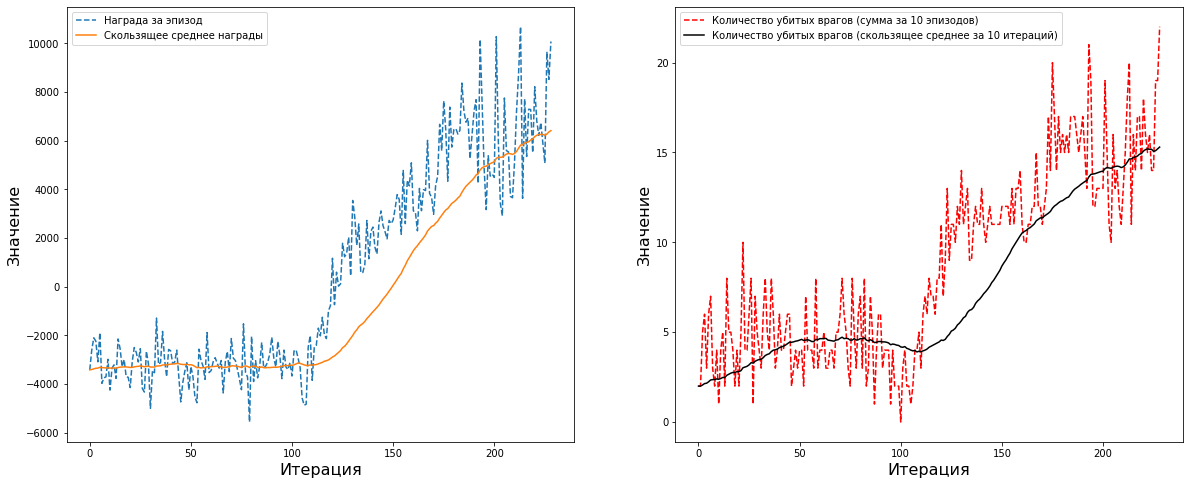

Статистика успешно сохранена.
Закончился 2290-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 2.0, количество оставшихся патронов: 50.0


In [ ]:
train_function(PER_A = 1)

Когда мы ставим значение `PER_A = 1`, это означает что сэмплирование данных становиться полностью приоритизированным, и агент в основном обучается на данных, где он максимально не правильно предсказывает значение Q(s, a). Как мы видим, агент способен обучаться вполне не плохо на этои.

Второй эксперимент:

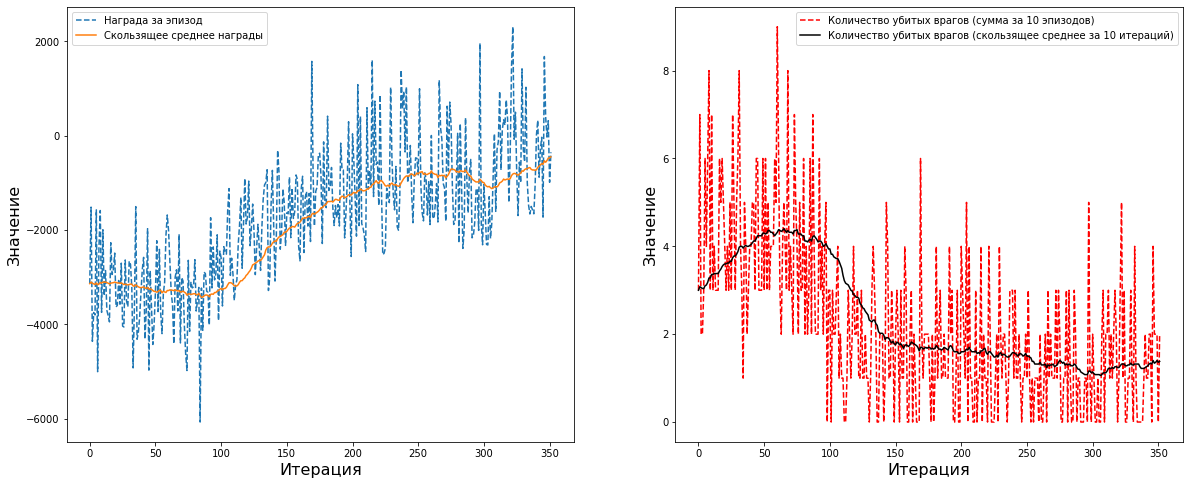

Статистика успешно сохранена.
Закончился 3520-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 2.0, количество оставшихся патронов: 52.0


In [ ]:
train_function(PER_A = -1)

Когда мы ставим значение `PER_A = -1`, это означает что сэмплирование данных становиться полностью не приоритизированным - агент редко обучается там, где он ошибся, и в основном обучается на данных, на которых он уже работает правильно. Не удивительно, что в таком случае агент обучается плохо.

Третий эксперимент:

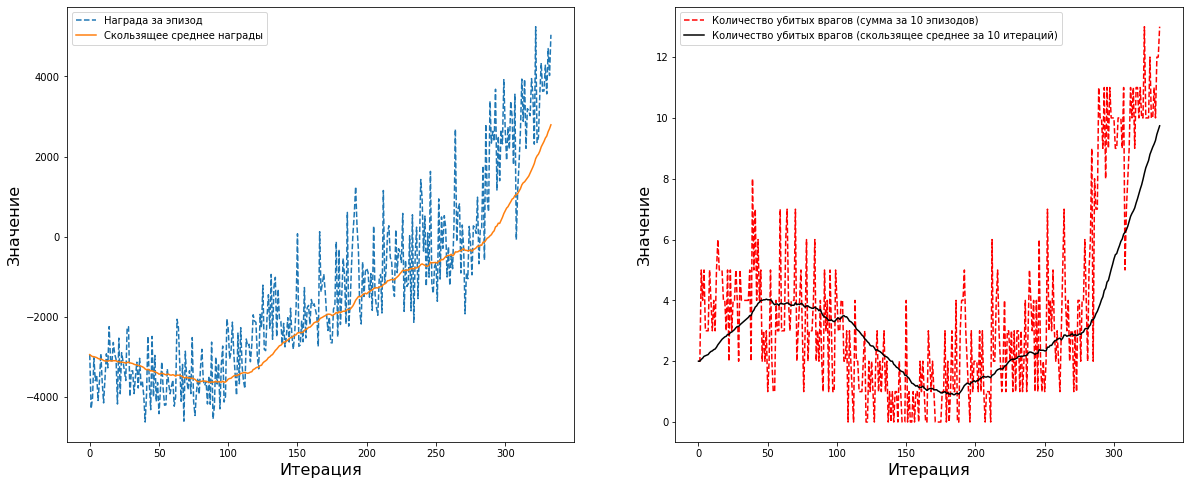

Статистика успешно сохранена.
Закончился 3340-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 1.0, количество оставшихся патронов: 51.0


In [ ]:
train_function(PER_B = 1, PER_B_increment_sampling = 0)

Когда мы ставим значение `PER_B = 1`, мы указываем что все данные, которые приоритизированны и извлекаются часто, будут иметь маленький вес. Практика показывает, что алгоритм способен на этом обучаться, но обучается медленее.

Четвертый эксперимент:

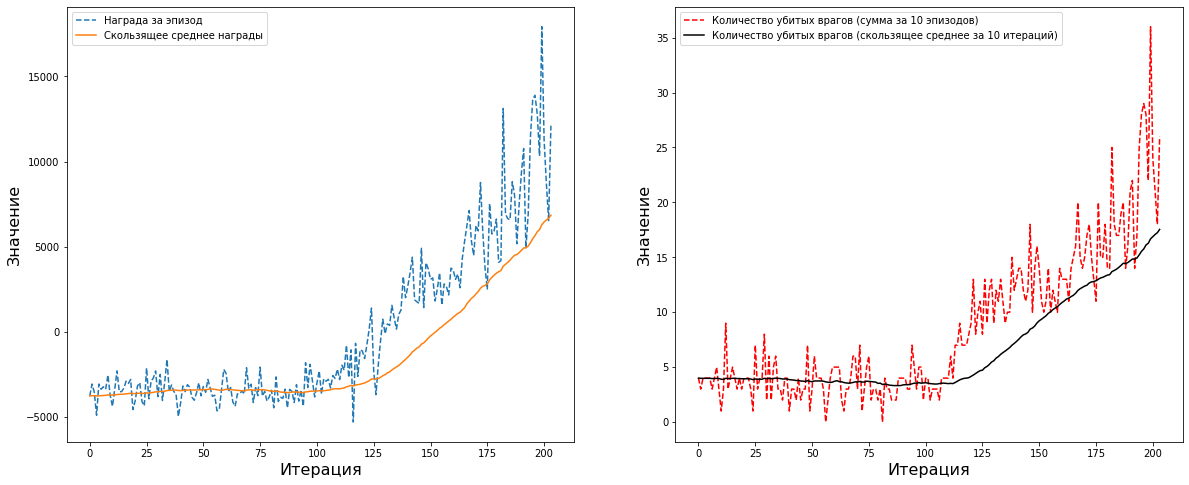

Статистика успешно сохранена.
Закончился 2040-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 1.0, количество оставшихся патронов: 51.0


In [ ]:
train_function(PER_B = 0, PER_B_increment_sampling = 0)

Когда мы ставим значение `PER_B = 0`, мы указываем что все данные будут иметь одинаковое значение в функции ошибки, в независимости от того, как часто они сэмплируются. Практика показывает, что алгоритм обучается на этом относительно хорошо.